# Antenna Position Measurement

Author: Tim Molteno. tim@elec.ac.nz.

The antennas are laid out on three arms which are placed approximately 120 degrees apart.  This notebook will use measurements to infer the actual layout of the antennas.

Arm 1 will point geographically north (NOT magnetic). This arm forms the y-axis and will be used as a reference.

The other reference point is the center of the array. This is assumed to be the point [0,0]. Make sure that a marker is present at this reference point at the same height as the level of the antennas (otherwise the distances will be wrong).

In [1]:
import numpy as np
from scipy.optimize import minimize 

In [2]:
x0 = [0,0]

In [9]:
# pip install pandas
# pip install odfpy

import pandas as pd

#pd.read_excel('three_arm_measurements.ods', engine='odf')
cols = [f"A {i}" for i in range(24)]
data = pd.read_excel('tart_rhodes_measurements.ods', "Sheet1", usecols=cols)
radius = data.loc[0]
radius

,A 0,A 1,A 2,A 3,A 4,A 5,A 6,A 7,A 8,A 9,...,A 14,A 15,A 16,A 17,A 18,A 19,A 20,A 21,A 22,A 23
0,210.0,410.0,384.0,638.0,212.0,753.0,1261.0,1436.0,1707.0,1864.0,...,1621.0,1924.0,2091.0,2408.0,914.0,1254.0,1575.0,1696.0,1856.0,2076.0
1,0.0,198.0,509.0,756.0,365.0,872.0,1054.0,1226.0,1489.0,1657.0,...,1718.0,2026.0,2187.0,2506.0,1027.0,1372.0,1691.0,1814.0,1969.0,2192.0


In [30]:
n_ant = 24
m_0 = np.zeros(24)
m_ij = np.zeros((24,24))

radius = data.loc[0]

for i in range(24):
    m_ij[i,:] = data.loc[i+1]

The following are the measured distances from [x1, x0, x2] from the reference points in millimeters. Note that their order must be the same as the order of the variable called 'reference_points'. In this case, they are x1,x0,x2.

In [13]:
m_ij

array([[   0.,  198.,  509.,  756.,  365.,  872., 1054., 1226., 1489.,
        1657., 1988., 2183., 1048., 1189., 1718., 2026., 2187., 2506.,
        1027., 1372., 1691., 1814., 1969., 2192.],
       [  nan,    0.,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,    0.,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,    0.,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,    0.,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan],
       [  nan,   nan,   nan,   nan,

In [31]:
radius

A 0      210.0
A 1      410.0
A 2      384.0
A 3      638.0
A 4      212.0
A 5      753.0
A 6     1261.0
A 7     1436.0
A 8     1707.0
A 9     1864.0
A 10    2199.0
A 11    2386.0
A 12     937.0
A 13    1084.0
A 14    1621.0
A 15    1924.0
A 16    2091.0
A 17    2408.0
A 18     914.0
A 19    1254.0
A 20    1575.0
A 21    1696.0
A 22    1856.0
A 23    2076.0
Name: 0, dtype: float64

## Plot the Initial Guess Points

Initial Guesses are from JSON queried from the telescope API. These are converted to millimeters.

In [15]:
import requests
import json

def get_data(path):
    server = "https://tart.elec.ac.nz/rhodes"

    r = requests.get('{}/{}'.format(server, path))
    return json.loads(r.text)

def get_pos():
    return np.array(get_data('api/v1/imaging/antenna_positions'))

current_pos = get_pos()
current_pos


array([[-0.03053484,  0.20814037,  0.        ],
       [-0.0593581 ,  0.40461381,  0.        ],
       [ 0.36115908, -0.14338736,  0.        ],
       [ 0.59236158, -0.23517936,  0.        ],
       [-0.16469739, -0.13028469,  0.        ],
       [-0.58917625, -0.46607082,  0.        ],
       [-0.18397281,  1.25404847,  0.        ],
       [-0.20960151,  1.42874624,  0.        ],
       [-0.24823413,  1.69208505,  0.        ],
       [-0.27005283,  1.84081194,  0.        ],
       [-0.31953728,  2.17812208,  0.        ],
       [-0.3463019 ,  2.36056282,  0.        ],
       [ 0.87568285, -0.34766355,  0.        ],
       [ 1.01211905, -0.40183145,  0.        ],
       [ 1.50515496, -0.59757653,  0.        ],
       [ 1.7908944 , -0.71102079,  0.        ],
       [ 1.94190228, -0.77097393,  0.        ],
       [ 2.23658088, -0.88796721,  0.        ],
       [-0.71308734, -0.56409131,  0.        ],
       [-0.98166989, -0.77655488,  0.        ],
       [-1.23517403, -0.9770906 ,  0.   

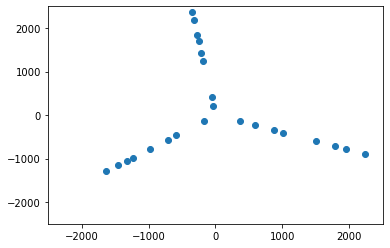

In [16]:
initial_guess = np.zeros(2*n_ant)

for i in range(n_ant):
    initial_guess[2*i:2*i+2] = current_pos[i][0:2]*1000
    #print(current_pos[i][0:2]*1000)
initial_guess

pos_i = current_pos*1000
import matplotlib.pyplot as plt
plt.scatter(pos_i[:,0], pos_i[:,1])
plt.xlim(-2500,2500)
plt.ylim(-2500,2500)
plt.show()

## Criteria for Optimality

The function below is minimized when the positions (in variable x) are consistent with the measured distances m[i,j]. The initial value of this function is more than 3 million.

Note that the x input is a 1D vector of with 48 entries as [p0.x, p0.y, p1.x, p1.y]

In [26]:
def dist(a,b):
    return np.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def p(x, i):
    return [x[2*i],x[2*i+1]]

center = [0,0]
def f(x):
    ret = 0
    for i in range(n_ant):
        p_i = p(x,i)
        ret += (dist(center, p_i) - m_0[i])**2
        for j in range(n_ant):
            p_j = p(x,j)
            if not np.isnan(m_ij[i,j]):
                ret += (dist(p_j, p_i) - m_ij[i,j])**2
    return ret

print(f(initial_guess))
res = minimize(f, initial_guess)
res

2469.0878530600353


      fun: 21.33333644036783
 hess_inv: array([[   1.61709218,    0.54343329,   -2.77496517, ...,   14.48573461,
          -9.87709846,   14.96446196],
       [   0.54343329,    0.30949621,   -2.34476467, ...,    5.9408704 ,
          -4.1169557 ,    6.19656003],
       [  -2.77496517,   -2.34476467,  276.18666423, ...,  -38.04027257,
          26.84134768,  -39.90885698],
       ...,
       [  14.48573461,    5.9408704 ,  -38.04027257, ...,  205.1712244 ,
         -93.06990415,  141.07731181],
       [  -9.87709846,   -4.1169557 ,   26.84134768, ...,  -93.06990415,
         108.12495618, -156.47865049],
       [  14.96446196,    6.19656003,  -39.90885698, ...,  141.07731181,
        -156.47865049,  227.79908463]])
      jac: array([-3.91006470e-05, -1.36375427e-04, -1.14440918e-05,  1.18732452e-04,
       -4.52995300e-06,  4.05311584e-06, -3.50475311e-05,  2.19345093e-05,
       -5.00679016e-06,  1.66893005e-06,  1.54972076e-05,  1.14440918e-05,
        1.93119049e-05, -4.14848328e-05

The optimized positions are now known. The final value of the function is 32. Far closer to zero than 3 million!

We can recover the x,y coordinates by reshaping the array

In [27]:
pos = res.x.reshape((24,2))
pos

array([[  -10.9172467 ,   212.38606852],
       [  -43.51403296,   407.68441913],
       [  358.38770429,  -137.89217893],
       [  586.71633972,  -250.61509525],
       [ -180.83116255,  -110.65302882],
       [ -648.83843622,  -382.12259267],
       [ -327.23935719,  1217.799481  ],
       [ -282.09104183,  1408.02008497],
       [  -87.60713412,  1702.08013552],
       [ -495.83677663,  1796.84233484],
       [ -372.95685091,  2167.14207183],
       [ -796.69340807,  2249.06104048],
       [  861.73432396,  -367.94422264],
       [ 1006.03119407,  -403.67956636],
       [ 1514.38482869,  -578.1691707 ],
       [ 1771.38482843,  -750.9805747 ],
       [ 1947.89957028,  -760.24219951],
       [ 2228.32595414,  -912.70329433],
       [ -795.12163046,  -450.75227905],
       [-1055.37835564,  -677.26841767],
       [-1323.71073359,  -853.47230749],
       [-1410.92790166,  -941.11555699],
       [-1568.83371887,  -991.71406285],
       [-1729.71866994, -1147.97619249]])

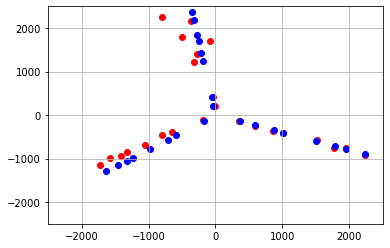

In [28]:
plt.scatter(pos[:,0], pos[:,1], color='red')
plt.scatter(pos_i[:,0], pos_i[:,1], color='blue')

plt.xlim(-2500,2500)
plt.ylim(-2500,2500)
plt.grid(True)
plt.show()

The API expects 3D coordinates (with a z value which is zero in this case). Therefore we add a column of zeros.

In [24]:
result = np.zeros((n_ant, 3))
result[:,:-1] = np.round(pos/1000.0, 3)
result

array([[-0.021,  0.205,  0.   ],
       [-0.059,  0.4  ,  0.   ],
       [ 0.355, -0.138,  0.   ],
       [ 0.593, -0.236,  0.   ],
       [-0.165, -0.13 ,  0.   ],
       [-0.584, -0.46 ,  0.   ],
       [-0.183,  1.247,  0.   ],
       [-0.208,  1.417,  0.   ],
       [-0.246,  1.677,  0.   ],
       [-0.27 ,  1.843,  0.   ],
       [-0.318,  2.171,  0.   ],
       [-0.347,  2.364,  0.   ],
       [ 0.871, -0.345,  0.   ],
       [ 1.004, -0.397,  0.   ],
       [ 1.499, -0.594,  0.   ],
       [ 1.787, -0.709,  0.   ],
       [ 1.937, -0.769,  0.   ],
       [ 2.234, -0.887,  0.   ],
       [-0.708, -0.558,  0.   ],
       [-0.981, -0.775,  0.   ],
       [-1.233, -0.975,  0.   ],
       [-1.329, -1.052,  0.   ],
       [-1.452, -1.148,  0.   ],
       [-1.627, -1.287,  0.   ]])

In [25]:
json_result = {}
json_result["antenna_positions"] = result.tolist()
print(json.dumps(json_result, indent=4, separators=(',', ': ')))

{
    "rhodes_antenna_positions": [
        [
            -0.021,
            0.205,
            0.0
        ],
        [
            -0.059,
            0.4,
            0.0
        ],
        [
            0.355,
            -0.138,
            0.0
        ],
        [
            0.593,
            -0.236,
            0.0
        ],
        [
            -0.165,
            -0.13,
            0.0
        ],
        [
            -0.584,
            -0.46,
            0.0
        ],
        [
            -0.183,
            1.247,
            0.0
        ],
        [
            -0.208,
            1.417,
            0.0
        ],
        [
            -0.246,
            1.677,
            0.0
        ],
        [
            -0.27,
            1.843,
            0.0
        ],
        [
            -0.318,
            2.171,
            0.0
        ],
        [
            -0.347,
            2.364,
            0.0
        ],
        [
            0.871,
            -0.345,
      

The position file above is in a format suitable for uploading to the telescope api. Also for using as the calibrated_antenna_positions.json file in TART/software/containers/telescope_web_api/config_data.


    tart_upload_antenna_positions --api https://tart.elec.ac.nz/rhodes --pw=xxxx --file rhodes_antenna_positions.json
